<a href="https://colab.research.google.com/github/andysingal/machine-learning/blob/main/scikitPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install feature_engine

The data set: Newspaper churn
The used dataset is from a former Kaggle competition and under CC0: Public Domain license. It contains 15.855 records and 19 columns including the target variable Subscriber (YES/NO). The majority of the features is categorial.

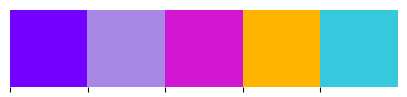

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

#Sklearn
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, 
                                     RepeatedStratifiedKFold, cross_validate)

# Assemble pipeline(s)
from sklearn import set_config
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Handle constant/duplicates and missing features/columns
from feature_engine.selection import (DropFeatures, DropConstantFeatures, 
                                      DropDuplicateFeatures)

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform

set_config(display="diagram")  # make pipeline visible

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Color Palette
custom_colors = ['#7400ff', '#a788e4', '#d216d2', '#ffb500', '#36c9dd']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [10]:
def load_process():
    df = pd.read_excel("NewspaperChurn new version.xlsx")
    df.columns = [k.lower().replace(" ", "_") for k in df.columns]
    df.rename(columns={'subscriber':'churn'}, inplace=True)
    df['churn'].replace({'NO':False, 'YES':True}, inplace=True)

    df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
    return df
df = load_process()
df.head()


,subscriptionid,hh_income,home_ownership,ethnicity,dummy_for_children,year_of_residence,age_range,language,address,state,city,county,zip_code,weekly_fee,deliveryperiod,nielsen_prizm,reward_program,source_channel,churn
0,180590686,"$ 30,000 - $39,999",RENTER,German,N,1,25-29,German,1 3RD PL UNIT 703,CA,LONG BEACH,LOS ANGELES,90802,$7.00 - $7.99,7Day,FM,0,CircAdm,False
1,181401653,"$500,000 Plus",OWNER,unknown,Y,14,50-54,NaN,1 AVIGNON,CA,NEWPORT COAST,ORANGE,92657,$0.01 - $0.50,SunOnly,MW,0,Partner,True
2,180374685,"$100,000 - $124,999",OWNER,Italian,Y,7,45-49,English,1 BLACKSWAN,CA,IRVINE,ORANGE,92604,$0.01 - $0.50,SunOnly,MW,0,Partner,True
3,180703483,"$200,000 - $249,999",OWNER,English,N,23,55-59,English,1 BLUE HORIZON,CA,LAGUNA NIGUEL,ORANGE,92677,$1.00 - $1.99,SunOnly,MW,1,Internet,False
4,180358906,"$ 50,000 - $59,999",OWNER,Italian,N,23,60-64,English,1 BRISA DEL LAGO,CA,RANCHO SANTA MARGARITA,ORANGE,92688,$8.00 - $8.99,Thu-Sun,MM,0,Crew,True


In [8]:
#Check null values 
def checking_null_values(df):
    #create a for loop that will return which columns have null values 
    na_columns = [col for col in df.columns if df[col].isna().sum()>0]
    #We find the null values in the null columns this value or arranged in ascending order
    na_miss = df[na_columns].isna().sum().sort_values(ascending=False)
    #this will be multiplication with 100 converts into percentage 
    ratio = (df[na_columns].isna().sum()/df.shape[0]*100).sort_values(ascending=False)
    #concat the missing_values and percentage with np.round
    missing_df = pd.concat([na_miss,np.round(ratio,2)], axis=1,keys= ['Null Values', 'Percentage'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df.style.background_gradient(cmap='winter_r')

checking_null_values(df)

,Null Values,Percentage
language,1007,6.350000
weekly_fee,186,1.170000
nielsen_prizm,129,0.810000
age_range,108,0.680000


#Step 1: Exclude features
The first step in our pipeline is to exclude or drop columns that will not help us in our prediction. The column subscriptionid, for example, has per row a different value, which makes sense, but this feature is not beneficial for our modeling step. We can also exclude features that are duplicated (e.g., having the same column with the same values twice or more) and containing a constant value.

The code above creates a pipeline object (line 1) and adds three steps (lines 3–5). The steps are defined as tuples, the first element defines the step’s name (e.g., ‘drop_columns’) and the second the transformer (e.g., DropFeatures()).

In [9]:
ppl = Pipeline([
    # Step 1: Drop irrelevant columns/features
    ('drop_columns', DropFeatures(['subscriptionid'])),
    ('drop_constant_values', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures())
])

# Step 2: Impute and transform values
After we dropped irrelevant columns, we focus now on dealing with missing values and feature scaling. Our data set contains different types of columns (integer and categorial). That’s why we have to define two separate workflows.

In [11]:
ppl = Pipeline([
    # Step 1: Drop irrelevant columns/features
    ('drop_columns', DropFeatures(['subscriptionid'])),
    ('drop_constant_values', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures()),
    
    # Step 2: Impute and scale columns/features
    ('cleaning', ColumnTransformer([
        # Step 2.1: Apply steps for numerical features
        ('num',make_pipeline(
            SimpleImputer(strategy='mean'),
            MinMaxScaler()),
         make_column_selector(dtype_include='int64')
        ),
        # Step 2.2 Apply steps for categorial features
        ('cat',make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse=False, handle_unknown='ignore')),
         make_column_selector(dtype_include='category')
        )])
    )
])

#Step 3: Sampling
A big challenge in churn- or fraud classification is to deal with class imbalance. Imblearn provides a battery of sampling methods that you can apply. In this example, we will use the SMOTE sampling method

In [12]:
ppl = Pipeline([
    # Step 1: Drop irrelevant columns/features
    ('drop_columns', DropFeatures(['subscriptionid'])),
    ('drop_constant_values', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures()),
    
    # Step 2: Impute and scale columns/features
    ('cleaning', ColumnTransformer([
        # Step 2.1: Apply steps for numerical features
        ('num',make_pipeline(
            SimpleImputer(strategy='mean'),
            MinMaxScaler()),
         make_column_selector(dtype_include='int64')
        ),
        # Step 2.2 Apply steps for categorial features
        ('cat',make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse=False, handle_unknown='ignore')),
         make_column_selector(dtype_include='category')
        )])
    ),
    # Step 3: Sampling
    ('smote', SMOTE())
])

In [13]:
ppl

Pipeline(steps=[('drop_columns',
                 DropFeatures(features_to_drop=['subscriptionid'])),
                ('drop_constant_values',
                 DropConstantFeatures(missing_values='ignore')),
                ('drop_duplicates', DropDuplicateFeatures()),
                ('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f12c1eb4670>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f12c1eb72e0>)])),
                ('smote', SMOTE())])

The pipeline object provides a method called get_feature_names_out(). But before using it, we have to fit the pipeline on our data set. Since step 3 (SMOTE) focuses on our y-data only, we can ignore it and focus on steps 1–2

In [14]:
X = df.drop("churn", axis=1)
y = df["churn"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [15]:
ppl_fts = ppl[0:4]
ppl_fts.fit(X_train, y_train)
features = ppl_fts.get_feature_names_out()
pd.Series(features)

0                    num__year_of_residence
1                             num__zip_code
2                       num__reward_program
3        cat__hh_income_$  20,000 - $29,999
4        cat__hh_income_$  30,000 - $39,999
                        ...                
12909               cat__source_channel_TMC
12910            cat__source_channel_TeleIn
12911           cat__source_channel_TeleOut
12912               cat__source_channel_VRU
12913          cat__source_channel_iSrvices
Length: 12914, dtype: object

#Step 4: Building the ensemble classifier
Now it is time to build our ensemble or voting classifier. In this example we want to use the mean prediction of the three models below (lines 2–6). Thats why we set the voting parameter to soft

In [16]:
# Linear model (logistic regression)
lr = LogisticRegression(warm_start=True, max_iter=400)
# RandomForest
rf = RandomForestClassifier()
# XGB
xgb = XGBClassifier(tree_method="hist", verbosity=0, silent=True)
# Ensemble
lr_xgb_rf = VotingClassifier(estimators=[('lr', lr), ('xgb', xgb), ('rf', rf)], 
                             voting='soft')

In [17]:
ppl = imbPipeline([ # It would crash with the Pipeline object from sklearn
    # Step 1: Drop irrelevant columns/features
    ('drop_columns', DropFeatures(['subscriptionid'])),
    ('drop_constant_values', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures()),
    
    # Step 2: Impute and scale columns/features
    ('cleaning', ColumnTransformer([
        # Step 2.1: Apply steps for numerical features
        ('num',make_pipeline(
            SimpleImputer(strategy='mean'),
            MinMaxScaler()),
         make_column_selector(dtype_include='int64')
        ),
        # Step 2.2 Apply steps for categorial features
        ('cat',make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse=False, handle_unknown='ignore')),
         make_column_selector(dtype_include='category')
        )])
    ),
    
    # Step 3: Sampling
    ('smote', SMOTE()),
    
    # Step 4: Voting Classifier
    ('ensemble', lr_xgb_rf)
])

In [18]:
ppl

Pipeline(steps=[('drop_columns',
                 DropFeatures(features_to_drop=['subscriptionid'])),
                ('drop_constant_values',
                 DropConstantFeatures(missing_values='ignore')),
                ('drop_duplicates', DropDuplicateFeatures()),
                ('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose....
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...)),
                                              ('rf', RandomForestClassifier())],
                                  voting='soft'))])

#Step 5: Hyperparameter tuning and feature importance
Hyperparameter tuning
The code below shows how to apply hyperparameter tuning by using RandomizedSearchCV.

In [ ]:
# Hyperparameter Tuning
params = {
    'ensemble__lr__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'ensemble__lr__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'ensemble__lr__C': loguniform(1e-5, 100),
    'ensemble__xgb__learning_rate': [0.1],
    'ensemble__xgb__max_depth': [7, 10, 15, 20],
    'ensemble__xgb__min_child_weight': [10, 15, 20, 25],
    'ensemble__xgb__colsample_bytree': [0.8, 0.9, 1],
    'ensemble__xgb__n_estimators': [300, 400, 500, 600],
    'ensemble__xgb__reg_alpha': [0.5, 0.2, 1],
    'ensemble__xgb__reg_lambda': [2, 3, 5],
    'ensemble__xgb__gamma': [1, 2, 3],
    'ensemble__rf__max_depth': [7, 10, 15, 20],
    'ensemble__rf__min_samples_leaf': [1, 2, 4],
    'ensemble__rf__min_samples_split': [2, 5, 10],
    'ensemble__rf__n_estimators': [300, 400, 500, 600],
}

rsf = RepeatedStratifiedKFold(random_state=42)
clf = RandomizedSearchCV(ppl, params,scoring='roc_auc', verbose=2, cv=rsf)
clf.fit(X_train, y_train)

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)
print("AUC:", roc_auc_score(y_val, clf.predict(X_val)))

Fitting 50 folds for each of 10 candidates, totalling 500 fits
[CV] END ensemble__lr__C=0.0033843430046832353, ensemble__lr__penalty=l1, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=10, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.2, ensemble__xgb__reg_lambda=2; total time= 4.2min


#Feature importance plot
To create a feature importance plot using our pipeline we make use of permutation importance.

In [ ]:
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html
def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """
    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])
    ax.set_yticks(range(len(indices)))
    ax.set_title("Permutation importance")
    
    tmp = np.array(feat_name)
    _ = ax.set_yticklabels(tmp[indices])

# Extract feature names after the transformation steps
# Therefore, we have to fit one part ([0:4]) of our pipeline to our data
ppl_fts = ppl[0:4]
ppl_fts.fit(X_train, y_train)
features = ppl_fts.get_feature_names_out()

# We provide the function our hyperparameter-tuned model/pipeline: clf
# In case we do not use hyperparameter tuning, we could provide here a fitted version of ppl
# For example: ppl.fit(X_train, y_train)
perm_importance_result_train = permutation_importance(clf, X_train, y_train, random_state=42)
plot_feature_importances(perm_importance_result_train, features)
#https://towardsdatascience.com/advanced-pipelines-with-scikit-learn-4204bb71019b
#https://www.linkedin.com/pulse/5-advanced-scikit-learn-features-transform-way-you-code-deena-gergis/